In [1]:
import sys
sys.path.extend(["../"])
from core.models.baseline_rnn import *
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
model = BaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...


In [3]:
saver = tf.train.Saver()

In [4]:
import sys
sys.path.extend(["../"])
from core.tools.data_import import *
from core.tools.time_series import *

In [5]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 36

In [6]:
df = load_dataset("/home/qinchenwang/AnnEconForecast/data/UNRATE.csv")
prepared_df = differencing(df, periods=PERIODS, order=ORDER)
prepared_df.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


In [7]:
X_raw, y_raw = gen_supervised_sequence(
    prepared_df, LAGS, prepared_df.columns[0], sequential_label=True)

Total 812 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (812, 36, 1), y shape = (812, 36, 1)


In [8]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "../model.ckpt")
    if model.SL:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    else:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})
    pred = gen_pred(X_raw)

INFO:tensorflow:Restoring parameters from ../model.ckpt


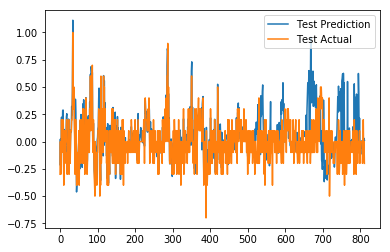

In [9]:
if model.SL:
    plt.plot(np.squeeze(pred[:,-1]))
    plt.plot(np.squeeze(y_raw[:,-1]))
else:
    plt.plot(np.squeeze(pred))
    plt.plot(np.squeeze(y_raw))
plt.legend(["Test Prediction", "Test Actual"])

In [10]:
print(pred.shape)
print(y_raw[:, -1].shape)
print(len(y_raw))
print(y_raw[:, -1][2])

(812, 1)
(812, 1)
812
[-0.3000002]


In [11]:
# start with initial credibility
cred = 1000
for i in range(len(y_raw)):
    if y_raw[i][0] * pred[i][0] >= 0:
        # predicted the same sign
        cred += 1
    else:
        cred -= 1
print(cred)

1122


## Using datapoint one day before

In [13]:
one_day_before_cred = 1000
for i in range(len(y_raw) - 1):
    if y_raw[i+1][0] * y_raw[i][0] >= 0:
        # predicted the same sign
        one_day_before_cred += 1
    else:
        one_day_before_cred -= 1
print(one_day_before_cred)

1381
